In [17]:
!git clone https://github.com/polimi-ispl/icpr2020dfdc
!pip install efficientnet-pytorch
!pip install -U git+https://github.com/albu/albumentations > /dev/null
%cd icpr2020dfdc/notebook

Cloning into 'icpr2020dfdc'...
remote: Enumerating objects: 616, done.
remote: Counting objects: 100% (616/616), done.
remote: Compressing objects: 100% (535/535), done.
remote: Total 616 (delta 318), reused 322 (delta 49), pack-reused 0
Receiving objects: 100% (616/616), 68.57 MiB | 38.69 MiB/s, done.
Resolving deltas: 100% (318/318), done.
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-cp37-none-any.whl size=16443 sha256=d4af88cf071db38394dbe114dc137a0abce45a402b3511b293ea19bb1f79373b
  Stored in directory: /root/.cache/pip/wheels/84/27/aa/c46d23c4e8cc72d41283862b1437e0b3ad318417e8ed7d5921
Successfully built efficientnet-pytorch
  Running command git clone -q https://github.com/albu/albumentations /tmp/pip-req-build-27s2roc2
/content/icpr2020dfdc/notebook


In [18]:
import pandas as pd
import io
from google.colab import files
import numpy as np
import torch
import matplotlib.pyplot as plt
from torch.utils.model_zoo import load_url
from scipy.special import expit

import sys
sys.path.append('..')

from blazeface import FaceExtractor, BlazeFace, VideoReader
from architectures import fornet,weights
from isplutils import utils

In [19]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
face_policy = 'scale'
face_size = 224
frames_per_video = 32

net_model = ['EfficientNetB4', 'EfficientNetB4ST', 'EfficientNetAutoAttB4', 'EfficientNetAutoAttB4ST', 'Xception']

train_db = ['DFDC', 'FFPP']

In [20]:
model_url = []
net = []
for train_num in range(2):
  for model_num in range(5):
    model_url.append(weights.weight_url['{:s}_{:s}'.format(net_model[model_num],train_db[train_num])])
    net.append(getattr(fornet,net_model[model_num])().eval().to(device))
    net[model_num + (5 * train_num)].load_state_dict(load_url(model_url[model_num + (5 * train_num)],map_location=device,check_hash=True))

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b4-6ed6700e.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b4-6ed6700e.pth



Loaded pretrained weights for efficientnet-b4


Downloading: "https://f002.backblazeb2.com/file/icpr2020/EfficientNetB4_DFDC_bestval-c9f3663e2116d3356d056a0ce6453e0fc412a8df68ebd0902f07104d9129a09a.pth" to /root/.cache/torch/hub/checkpoints/EfficientNetB4_DFDC_bestval-c9f3663e2116d3356d056a0ce6453e0fc412a8df68ebd0902f07104d9129a09a.pth



Loaded pretrained weights for efficientnet-b4


Downloading: "https://f002.backblazeb2.com/file/icpr2020/EfficientNetB4ST_DFDC_bestval-86f0a0701b18694dfb5e7837bd09fa8e48a5146c193227edccf59f1b038181c6.pth" to /root/.cache/torch/hub/checkpoints/EfficientNetB4ST_DFDC_bestval-86f0a0701b18694dfb5e7837bd09fa8e48a5146c193227edccf59f1b038181c6.pth



Loaded pretrained weights for efficientnet-b4


Downloading: "https://f002.backblazeb2.com/file/icpr2020/EfficientNetAutoAttB4_DFDC_bestval-72ed969b2a395fffe11a0d5bf0a635e7260ba2588c28683630d97ff7153389fc.pth" to /root/.cache/torch/hub/checkpoints/EfficientNetAutoAttB4_DFDC_bestval-72ed969b2a395fffe11a0d5bf0a635e7260ba2588c28683630d97ff7153389fc.pth



Loaded pretrained weights for efficientnet-b4


Downloading: "https://f002.backblazeb2.com/file/icpr2020/EfficientNetAutoAttB4ST_DFDC_bestval-4df0ef7d2f380a5955affa78c35d0942ac1cd65229510353b252737775515a33.pth" to /root/.cache/torch/hub/checkpoints/EfficientNetAutoAttB4ST_DFDC_bestval-4df0ef7d2f380a5955affa78c35d0942ac1cd65229510353b252737775515a33.pth


Downloading: "http://data.lip6.fr/cadene/pretrainedmodels/xception-43020ad28.pth" to /root/.cache/torch/hub/checkpoints/xception-43020ad28.pth


Downloading: "https://f002.backblazeb2.com/file/icpr2020/Xception_DFDC_bestval-e826cdb64d73ef491e6b8ff8fce0e1e1b7fc1d8e2715bc51a56280fff17596f9.pth" to /root/.cache/torch/hub/checkpoints/Xception_DFDC_bestval-e826cdb64d73ef491e6b8ff8fce0e1e1b7fc1d8e2715bc51a56280fff17596f9.pth



Loaded pretrained weights for efficientnet-b4


Downloading: "https://f002.backblazeb2.com/file/icpr2020/EfficientNetB4_FFPP_bestval-93aaad84946829e793d1a67ed7e0309b535e2f2395acb4f8d16b92c0616ba8d7.pth" to /root/.cache/torch/hub/checkpoints/EfficientNetB4_FFPP_bestval-93aaad84946829e793d1a67ed7e0309b535e2f2395acb4f8d16b92c0616ba8d7.pth



Loaded pretrained weights for efficientnet-b4


Downloading: "https://f002.backblazeb2.com/file/icpr2020/EfficientNetB4ST_FFPP_bestval-ccd016668071be5bf5fff68e446d055441739ec7113fb1a6eee998f08396ae92.pth" to /root/.cache/torch/hub/checkpoints/EfficientNetB4ST_FFPP_bestval-ccd016668071be5bf5fff68e446d055441739ec7113fb1a6eee998f08396ae92.pth



Loaded pretrained weights for efficientnet-b4


Downloading: "https://f002.backblazeb2.com/file/icpr2020/EfficientNetAutoAttB4_FFPP_bestval-b0c9e9522a7143cf119843e910234be5e30f77dc527b1b427cdffa5ce3bdbc25.pth" to /root/.cache/torch/hub/checkpoints/EfficientNetAutoAttB4_FFPP_bestval-b0c9e9522a7143cf119843e910234be5e30f77dc527b1b427cdffa5ce3bdbc25.pth



Loaded pretrained weights for efficientnet-b4


Downloading: "https://f002.backblazeb2.com/file/icpr2020/EfficientNetAutoAttB4ST_FFPP_bestval-ddb357503b9b902e1b925c2550415604c4252b9b9ecafeb7369dc58cc16e9edd.pth" to /root/.cache/torch/hub/checkpoints/EfficientNetAutoAttB4ST_FFPP_bestval-ddb357503b9b902e1b925c2550415604c4252b9b9ecafeb7369dc58cc16e9edd.pth


Downloading: "https://f002.backblazeb2.com/file/icpr2020/Xception_FFPP_bestval-bb119e4913cb8f816cd28a03f81f4c603d6351bf8e3f8e3eb99eebc923aecd22.pth" to /root/.cache/torch/hub/checkpoints/Xception_FFPP_bestval-bb119e4913cb8f816cd28a03f81f4c603d6351bf8e3f8e3eb99eebc923aecd22.pth


In [21]:
facedet = BlazeFace().to(device)
facedet.load_weights("../blazeface/blazeface.pth")
facedet.load_anchors("../blazeface/anchors.npy")
videoreader = VideoReader(verbose=False)
video_read_fn = lambda x: videoreader.read_frames(x, num_frames=50)
face_extractor = FaceExtractor(video_read_fn=video_read_fn,facedet=facedet)

transf = []
for x in range(10):
  transf.append(utils.get_transformer(face_policy, face_size, net[x].get_normalizer(), train=False))

In [24]:
from datetime import datetime

In [25]:
def test_10_models(filename, label):
  testimages = face_extractor.process_video(filename)
  testimages_real_face = []
  if (testimages != []):
    for x in range(10):
      testimages_real_face.append(torch.stack( [ transf[x](image=frame['faces'][0])['image'] for frame in testimages if len(frame['faces'])] ))

    result = [0,0,0,0,0,0,0,0,0,0]
    now = datetime.now()
    with torch.no_grad():
        result[0] = expit((net[0](testimages_real_face[0].to(device)).cpu().numpy().flatten())).mean()
        model1t = datetime.now()
        result[1] = expit((net[1](testimages_real_face[1].to(device)).cpu().numpy().flatten())).mean()
        model2t = datetime.now()
        result[2] = expit((net[2](testimages_real_face[2].to(device)).cpu().numpy().flatten())).mean()
        model3t = datetime.now()
        result[3] = expit((net[3](testimages_real_face[3].to(device)).cpu().numpy().flatten())).mean()
        model4t = datetime.now()
        result[4] = expit((net[4](testimages_real_face[4].to(device)).cpu().numpy().flatten())).mean()
        model5t = datetime.now()
        result[5] = expit((net[5](testimages_real_face[5].to(device)).cpu().numpy().flatten())).mean()
        model6t = datetime.now()
        result[6] = expit((net[6](testimages_real_face[6].to(device)).cpu().numpy().flatten())).mean()
        model7t = datetime.now()
        result[7] = expit((net[7](testimages_real_face[7].to(device)).cpu().numpy().flatten())).mean()
        model8t = datetime.now()
        result[8] = expit((net[8](testimages_real_face[8].to(device)).cpu().numpy().flatten())).mean()
        model9t = datetime.now()
        result[9] = expit((net[9](testimages_real_face[9].to(device)).cpu().numpy().flatten())).mean()
        model10t = datetime.now()

    correct = [0,0,0,0,0,0,0,0,0,0]
    line = 0.5

    if (label == "FAKE"):
      for y in range(10):
        if (result[y] > line):
          correct[y] = 1
    else:
      for y in range(10):
        if (result[y] < line):
          correct[y] = 1

    print(filename)
    print(correct)
    print(result)
    print(model1t - now)
    print(model2t - model1t)
    print(model3t - model2t)
    print(model4t - model3t)
    print(model5t - model4t)
    print(model6t - model5t)
    print(model7t - model6t)
    print(model8t - model7t)
    print(model9t - model8t)
    print(model10t - model9t)

  else:
    correct = [0,0,0,0,0,0,0,0,0,0]

  return correct

In [26]:
uploaded = files.upload()

Saving aagfhgtpmv.mp4 to aagfhgtpmv.mp4


In [27]:
bruh = test_10_models('aagfhgtpmv.mp4', 'FAKE')


aagfhgtpmv.mp4
[1, 1, 1, 0, 1, 0, 0, 0, 0, 0]
[0.9084592, 0.7130285, 0.5635453, 0.40511936, 0.74692917, 0.051925734, 0.05845308, 0.04137125, 0.045000974, 0.34303543]
0:00:14.724216
0:00:14.583908
0:00:14.546467
0:00:14.456393
0:00:12.379771
0:00:14.688523
0:00:14.723358
0:00:14.697490
0:00:14.672801
0:00:11.844742


In [30]:
torch.save(net[0], './model0.pth')
torch.save(net[1], './model1.pth')
torch.save(net[2], './model2.pth')
torch.save(net[3], './model3.pth')
torch.save(net[4], './model4.pth')
torch.save(net[5], './model5.pth')
torch.save(net[6], './model6.pth')
torch.save(net[7], './model7.pth')
torch.save(net[8], './model8.pth')
torch.save(net[9], './model9.pth')

import os
 
file_size0 = os.path.getsize('model0.pth')
print("File Size for Model 0:", file_size0, "bytes")
file_size1 = os.path.getsize('model1.pth')
print("File Size for Model 1:", file_size1, "bytes")
file_size2 = os.path.getsize('model2.pth')
print("File Size for Model 2:", file_size2, "bytes")
file_size3 = os.path.getsize('model3.pth')
print("File Size for Model 3:", file_size3, "bytes")
file_size4 = os.path.getsize('model4.pth')
print("File Size for Model 4:", file_size4, "bytes")
file_size5 = os.path.getsize('model5.pth')
print("File Size for Model 5:", file_size5, "bytes")
file_size6 = os.path.getsize('model6.pth')
print("File Size for Model 6:", file_size6, "bytes")
file_size7 = os.path.getsize('model7.pth')
print("File Size for Model 7:", file_size7, "bytes")
file_size8 = os.path.getsize('model8.pth')
print("File Size for Model 8:", file_size8, "bytes")
file_size9 = os.path.getsize('model9.pth')
print("File Size for Model 9:", file_size9, "bytes")

File Size for Model 0: 71007105 bytes
File Size for Model 1: 71045952 bytes
File Size for Model 2: 71008275 bytes
File Size for Model 3: 71047122 bytes
File Size for Model 4: 83574691 bytes
File Size for Model 5: 71007105 bytes
File Size for Model 6: 71045952 bytes
File Size for Model 7: 71008275 bytes
File Size for Model 8: 71047122 bytes
File Size for Model 9: 83574691 bytes


In [31]:
torch.save(lenet, './lenet.pth')

file_size0 = os.path.getsize('lenet.pth')
print("File Size for lenet:", file_size0, "bytes")

File Size for lenet: 1015505545 bytes


In [ ]:
best_model = test_10_models('aelfnikyqj.mp4', 0)

In [ ]:
def best_model_funct(fileList):
  model_tracker = np.array([0,0,0,0,0,0,0,0,0,0])
  for file in fileList.items():
    label = (file[1])['label']
    result = np.array(test_10_models(file[0], label))
    model_tracker = np.add(model_tracker, result)
  max = 0
  for x in range(10):
    if (model_tracker[x] > max):
      max = model_tracker[x]
      best = x

  if (best == 0 or best == 5):
    print('The best model is EfficientNetB4')
  elif (best == 1 or best == 6):
    print('The best model is EfficientNetB4ST')
  elif (best == 2 or best == 7):
    print('The best model is EfficientNetAutoAttB4')
  elif (best == 3 or best == 8):
    print('The best model is EfficientNetAutoAttB4ST')
  else:
    print('The best model is Xception')

  if (best < 5):
    print('with training set DFDC')
  else:
    print('with training set DFDC')

  return model_tracker

In [ ]:
uploaded = files.upload()
uploaded = files.upload()

In [ ]:
import json

In [ ]:
with open('metadata.json') as f:
  fileList = json.load(f)

results = best_model_funct(fileList)

aapnvogymq.mp4
[1, 1, 1, 1, 1, 0, 0, 0, 0, 0]
[0.6016274, 0.5679076, 0.6019603, 0.5482208, 0.67734534, 0.33167046, 0.26646507, 0.1525922, 0.11882168, 0.3512975]
abarnvbtwb.mp4
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[0.056915592, 0.08413155, 0.04564752, 0.11296556, 0.053294893, 0.11388126, 0.09679797, 0.08208319, 0.12565416, 0.06696843]
abofeumbvv.mp4
[1, 1, 1, 1, 1, 1, 1, 0, 0, 1]
[0.95978254, 0.84396863, 0.7717704, 0.90376127, 0.85673845, 0.6343939, 0.6556759, 0.46740046, 0.13703147, 0.6494561]
abqwwspghj.mp4
[1, 1, 1, 1, 1, 0, 0, 0, 0, 0]
[0.9988044, 0.9606103, 0.99716383, 0.90436584, 0.99566233, 0.10874223, 0.09979164, 0.13633822, 0.10975524, 0.25573432]
acifjvzvpm.mp4
[1, 1, 1, 0, 1, 0, 0, 0, 0, 0]
[0.8315741, 0.68609625, 0.6331646, 0.3919176, 0.942567, 0.14557548, 0.1979043, 0.14915308, 0.26045027, 0.15212947]
acqfdwsrhi.mp4
[1, 1, 1, 1, 1, 1, 1, 1, 1, 0]
[0.99109083, 0.9714708, 0.982854, 0.9624226, 0.97526217, 0.5627043, 0.6003996, 0.7550926, 0.5442753, 0.36740062]
acxnxvbsxk.mp4
[1, 1, 

In [ ]:
print(results)

NameError: ignored

In [ ]:
uploaded = files.upload()

Saving aagfhgtpmv.mp4 to aagfhgtpmv.mp4
Saving aapnvogymq.mp4 to aapnvogymq.mp4
Saving abarnvbtwb.mp4 to abarnvbtwb.mp4
Saving abofeumbvv.mp4 to abofeumbvv.mp4
Saving abqwwspghj.mp4 to abqwwspghj.mp4
Saving acifjvzvpm.mp4 to acifjvzvpm.mp4
Saving acqfdwsrhi.mp4 to acqfdwsrhi.mp4
Saving acxnxvbsxk.mp4 to acxnxvbsxk.mp4
Saving acxwigylke.mp4 to acxwigylke.mp4
Saving aczrgyricp.mp4 to aczrgyricp.mp4


In [ ]:
data = [['aapnvogymq.mp4', 'abarnvbtwb.mp4', 'abofeumbvv.mp4', 'abqwwspghj.mp4', 'acifjvzvpm.mp4', 'acqfdwsrhi.mp4', 'acxnxvbsxk.mp4', 'acxwigylke.mp4', 'aczrgyricp.mp4'], [float(0),float(1),float(0),float(0),float(0),float(0),float(0),float(0),float(0)]]

In [ ]:
model_url = weights.weight_url['{:s}_{:s}'.format('EfficientNetB4','FFPP')]
net = getattr(fornet,'EfficientNetB4')().eval().to(device)
net.load_state_dict(load_url(model_url,map_location=device,check_hash=True))

transf = utils.get_transformer(face_policy, face_size, net.get_normalizer(), train=False)

facedet = BlazeFace().to(device)
facedet.load_weights("../blazeface/blazeface.pth")
facedet.load_anchors("../blazeface/anchors.npy")
videoreader = VideoReader(verbose=False)
video_read_fn = lambda x: videoreader.read_frames(x, num_frames=frames_per_video)
face_extractor = FaceExtractor(video_read_fn=video_read_fn,facedet=facedet)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b4-6ed6700e.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b4-6ed6700e.pth



Loaded pretrained weights for efficientnet-b4


Downloading: "https://f002.backblazeb2.com/file/icpr2020/EfficientNetB4_FFPP_bestval-93aaad84946829e793d1a67ed7e0309b535e2f2395acb4f8d16b92c0616ba8d7.pth" to /root/.cache/torch/hub/checkpoints/EfficientNetB4_FFPP_bestval-93aaad84946829e793d1a67ed7e0309b535e2f2395acb4f8d16b92c0616ba8d7.pth


In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

In [2]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(44944, 5618)
        self.fc2 = nn.Linear(5618, 244)
        self.fc3 = nn.Linear(244, 1)


    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


lenet = Net()

In [ ]:
batch_size = 4

videos = []
faces = []
for vid in ['aapnvogymq.mp4', 'abarnvbtwb.mp4', 'abofeumbvv.mp4', 'abqwwspghj.mp4', 'acifjvzvpm.mp4', 'acqfdwsrhi.mp4', 'acxnxvbsxk.mp4', 'acxwigylke.mp4', 'aczrgyricp.mp4']:
  images = face_extractor.process_video(vid)
  faces.append(torch.stack( [ transf(image=frame['faces'][0])['image'] for frame in images if len(frame['faces'])] ))

labels = []
for aaa in range(9):
  for ccc in range(32):
    if aaa == 1:
      labels.append(1)
    else:
      labels.append(0)

data = [faces, labels]



trainset = data
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

In [ ]:
import torch.optim as optim
import torch.tensor as Tensor

criterion = nn.BCELoss().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [ ]:
for epoch in range(10):  # loop over the dataset multiple times

    running_loss = 0.0
        # get the inputs; data is a list of [inputs, labels]
    inputs, labels = data
    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    inputa = torch.cat((inputs[0], inputs[1], inputs[2], inputs[3], inputs[4], inputs[5], inputs[6], inputs[7], inputs[8]))
    inputa = inputa
    outputs = (lenet(inputa))

    print(outputs)
    labels = torch.FloatTensor(labels)

    outputs = outputs.flatten()

    loss = criterion(outputs, labels)
    
    loss.backward()
    optimizer.step()

    # print statistics
    print(loss.item())
    epoch = epoch + 1

print('Finished Training')

tensor([[0.0751],
        [0.0795],
        [0.0784],
        [0.0783],
        [0.0791],
        [0.0805],
        [0.0794],
        [0.0942],
        [0.1021],
        [0.0966],
        [0.0984],
        [0.0943],
        [0.1014],
        [0.1034],
        [0.0987],
        [0.1033],
        [0.1063],
        [0.0952],
        [0.0847],
        [0.0810],
        [0.0634],
        [0.0633],
        [0.0714],
        [0.0780],
        [0.0868],
        [0.0898],
        [0.0970],
        [0.0751],
        [0.0784],
        [0.0757],
        [0.0819],
        [0.0767],
        [0.0788],
        [0.0795],
        [0.0826],
        [0.0734],
        [0.0703],
        [0.0767],
        [0.0647],
        [0.0663],
        [0.0661],
        [0.0714],
        [0.0757],
        [0.0685],
        [0.0753],
        [0.0536],
        [0.0757],
        [0.0688],
        [0.0778],
        [0.0823],
        [0.0792],
        [0.0791],
        [0.0772],
        [0.0746],
        [0.0695],
        [0

In [ ]:
torch.save(lenet, './lenet.pth')

In [3]:
lenet

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=44944, out_features=5618, bias=True)
  (fc2): Linear(in_features=5618, out_features=244, bias=True)
  (fc3): Linear(in_features=244, out_features=1, bias=True)
)

In [6]:
uploaded = files.upload()


Saving metadata.json to metadata.json


In [8]:
import json

In [16]:
with open('metadata.json') as f:
  fileList = json.load(f)

nnn = 0
mmm = 0

for file in fileList.items():
  if ((file[1])['label'] == "FAKE" and mmm < 144):
      nnn = nnn + 1
  mmm = mmm + 1

print(nnn)

118


In [32]:
!git clone "https://github.com/jacobkimmel/pytorch_modelsize"

Cloning into 'pytorch_modelsize'...
remote: Enumerating objects: 26, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 26 (delta 0), reused 1 (delta 0), pack-reused 22
Unpacking objects: 100% (26/26), done.


In [33]:
from pytorch_modelsize import SizeEstimator

ImportError: ignored

<BarContainer object of 6 artists>

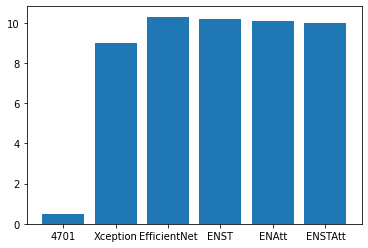

In [35]:
from matplotlib import pyplot

plt.bar(['4701', 'Xception', 'EfficientNet', 'ENST', 'ENAtt', 'ENSTAtt'], [0.5, 9, 10.3,10.2,10.1,10])
